In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

### Examine one session, plot

In [2]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
OUTPUT_DIR = "/data/patrick_scratch/information"

SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle"

session = 20180928
mi = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_features_mi.pickle"))
null = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_features_null_stats.pickle"))
shuffled_mis = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_features_null_shuffled.pickle"))

mi_rpe = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_rpe_mi.pickle"))
null_rpe = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_rpe_null_stats.pickle"))
shuffled_mis_rpe = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_rpe_null_shuffled.pickle"))


In [3]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FeedbackOnset"
fr_path = f"/data/patrick_scratch/multi_sess/{session}/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)
pos = spike_utils.get_unit_positions_per_sess(session)
pos = spike_utils.get_manual_structure(pos)

In [4]:
bon_feature_stats = information_utils.calc_corrected_null_stats(shuffled_mis, FEATURE_DIMS, p_val=0.05, num_hyp=15)
null = pd.merge(null, bon_feature_stats, on=["UnitID", "TimeBins"])

bon_rpe_stats = information_utils.calc_corrected_null_stats(shuffled_mis_rpe, ["RPEGroup"], p_val=0.05, num_hyp=15)
null_rpe = pd.merge(null_rpe, bon_rpe_stats, on=["UnitID", "TimeBins"])

In [5]:
mi_features_df = pd.merge(mi, null, on=["UnitID", "TimeBins"])
mi_rpe_df = pd.merge(mi_rpe, null_rpe, on=["UnitID", "TimeBins"])
mi_df = pd.merge(mi_features_df, mi_rpe_df, on=["UnitID", "TimeBins"])

In [6]:
unit_sig = information_utils.assess_significance(mi_df, FEATURE_DIMS + ["RPEGroup"])

In [7]:
sig_units = unit_sig[(unit_sig.ColorSig | unit_sig.ShapeSig | unit_sig.PatternSig) & unit_sig.RPEGroupSig].UnitID

In [8]:
len(mi_df.UnitID.unique())

22

In [42]:
len(sig_units)

10

In [43]:
sig_units = filtered_pos[filtered_pos.session == str(session)].UnitID.unique()

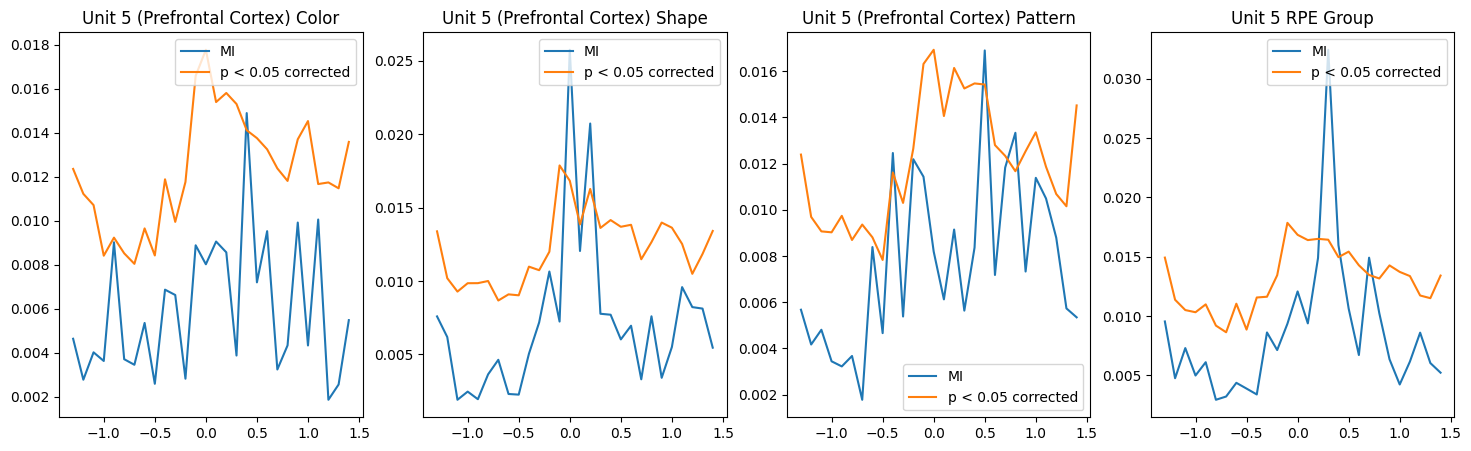

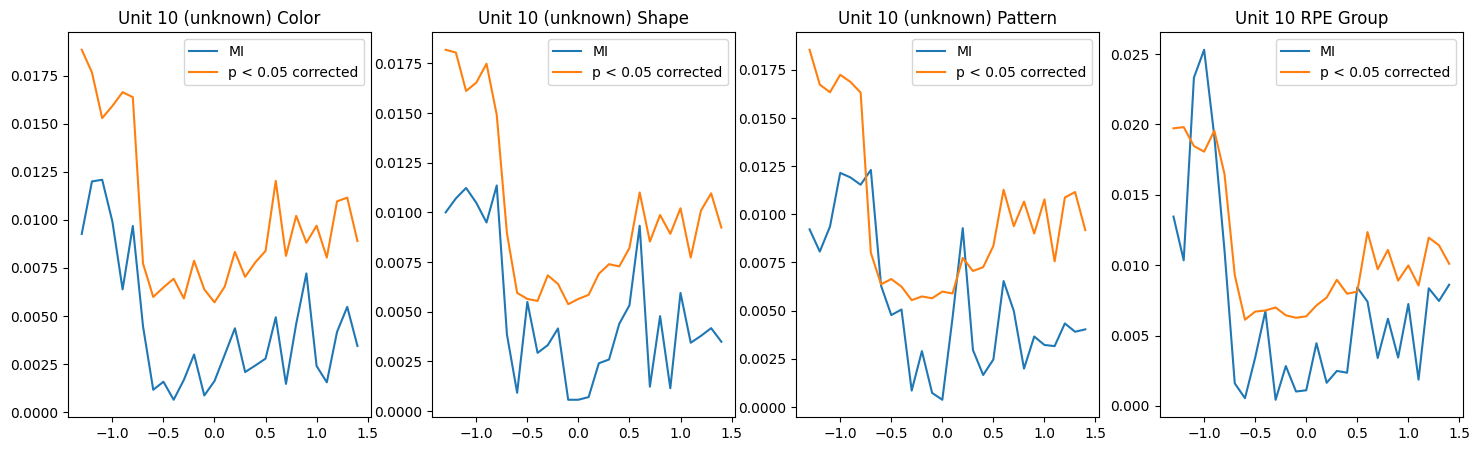

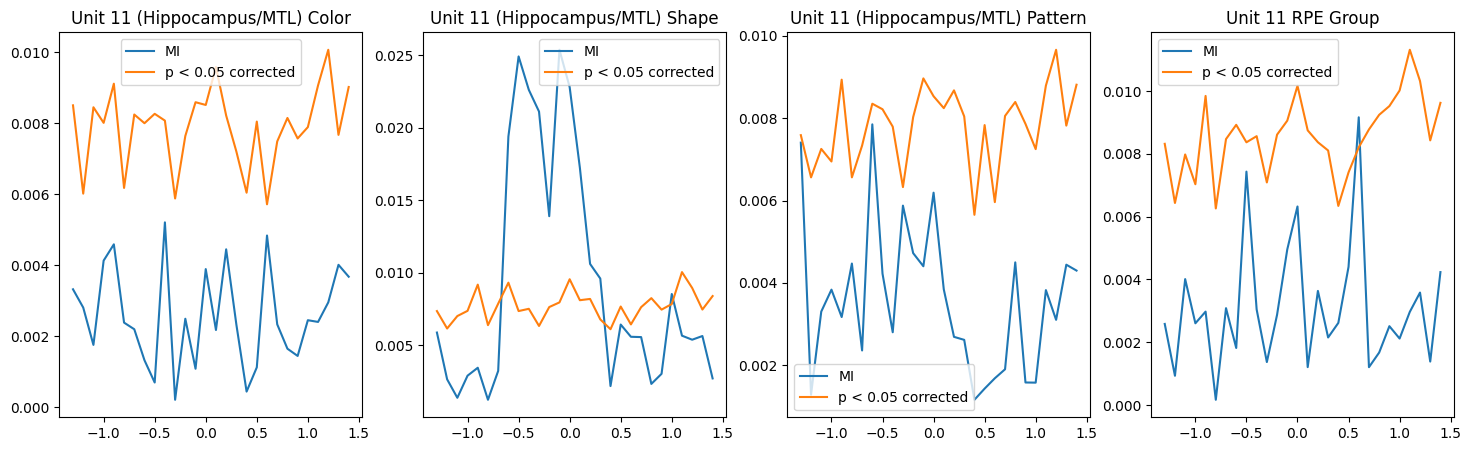

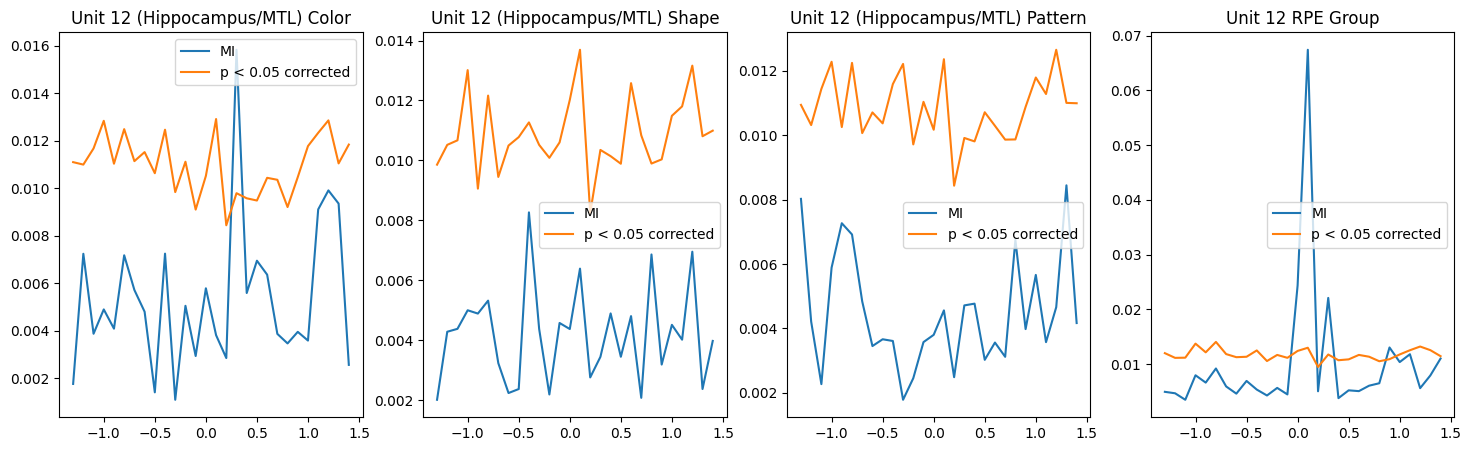

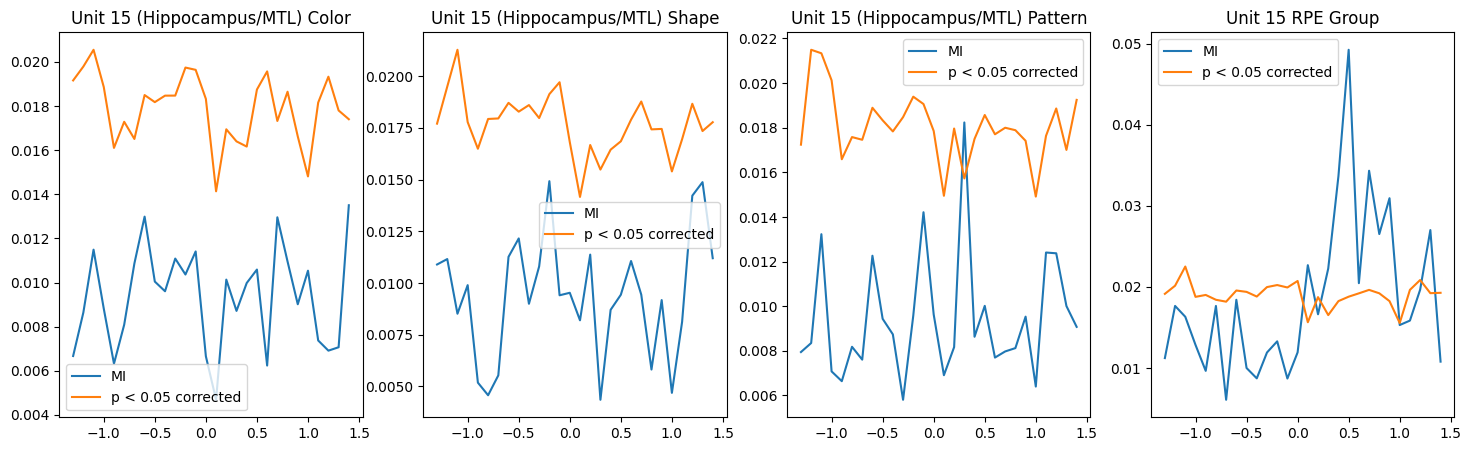

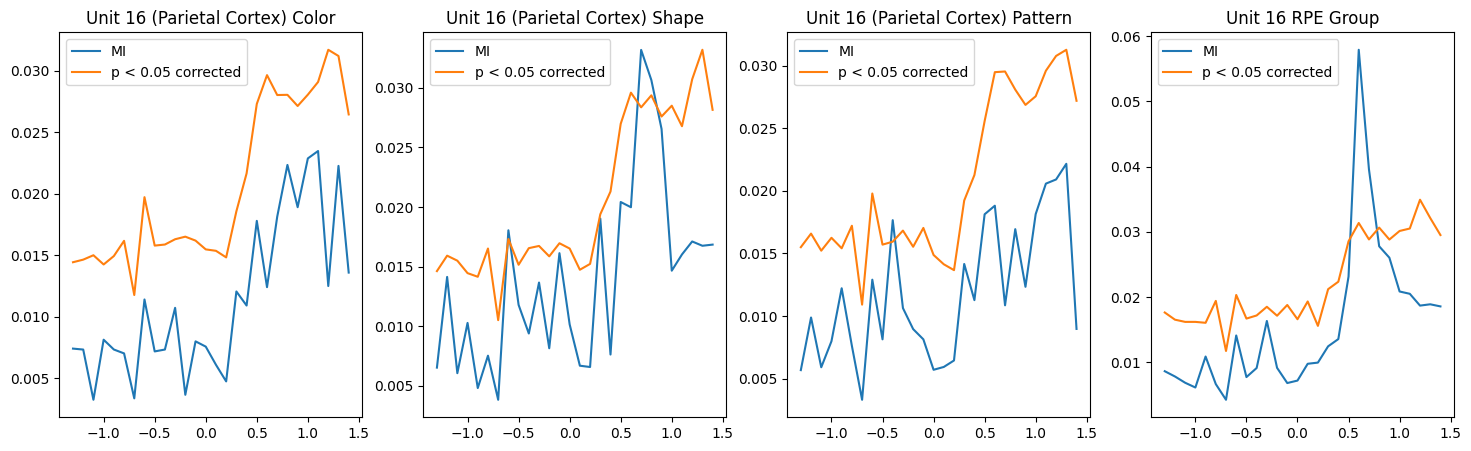

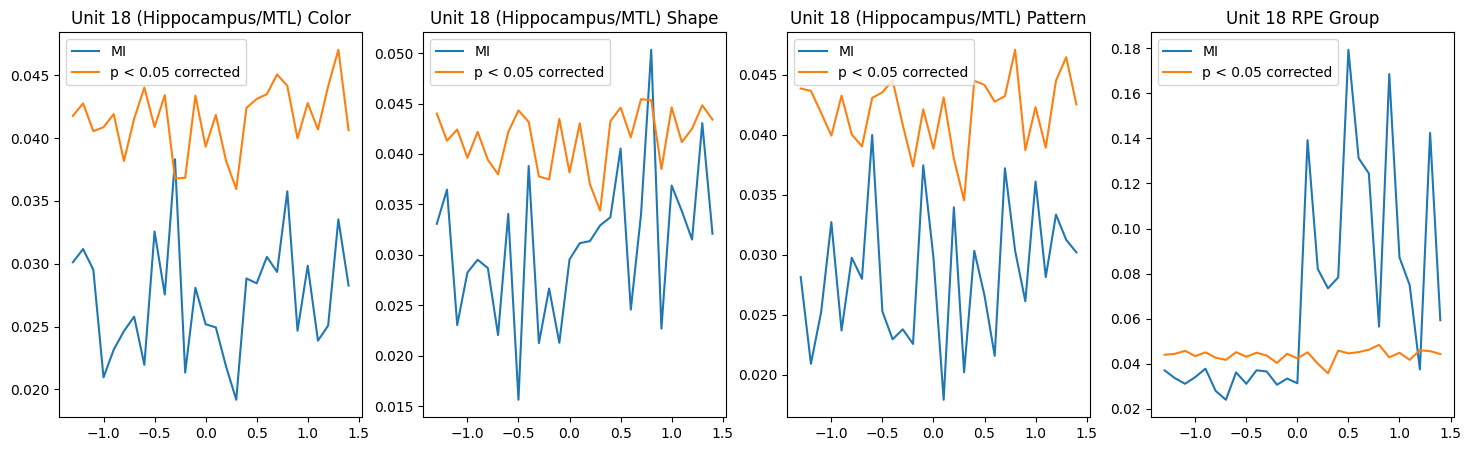

In [44]:
for unit in sig_units:
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    for i, feature in enumerate(FEATURE_DIMS):
        unit_pos = pos[pos.UnitID == unit].manual_structure.unique()[0]
        unit_mi = mi[mi.UnitID == unit]
        unit_null = null[null.UnitID == unit]
        time_bins = unit_mi.TimeBins - 1.3
        mi_vals = unit_mi[f"MI{feature}"]
        null_95 = unit_null[f"MIShuffled{feature}95th"]
        # null_99 = unit_null[f"MIShuffled{feature}99th"]
        null_95_cor = unit_null[f"MIShuffled{feature}Corrected"]
        axs[i].plot(time_bins, mi_vals, label="MI")
        # axs[i].plot(time_bins, null_95, label="p < 0.05")
        # axs[i].plot(time_bins, null_99, label="p < 0.01")
        axs[i].plot(time_bins, null_95_cor, label="p < 0.05 corrected")
        axs[i].set_title(f"Unit {unit} ({unit_pos}) {feature}")
        axs[i].legend()
    unit_rpe_mi = mi_rpe[mi_rpe.UnitID == unit]
    unit_rpe_null = null_rpe[null_rpe.UnitID == unit]
    time_bins = unit_rpe_mi.TimeBins - 1.3
    mi_vals = unit_rpe_mi[f"MIRPEGroup"]
    null_95_cor = unit_rpe_null[f"MIShuffledRPEGroupCorrected"]
    axs[3].plot(time_bins, mi_vals, label="MI")
    axs[3].plot(time_bins, null_95_cor, label="p < 0.05 corrected")
    axs[3].set_title(f"Unit {unit} RPE Group")
    axs[3].legend() 

### Do this for every session to form a sub-population 

In [9]:
def both_sig(unit_sig):
    return unit_sig[(unit_sig.ColorSig | unit_sig.ShapeSig | unit_sig.PatternSig) & unit_sig.RPEGroupSig]

def feature_sig(unit_sig):
    return unit_sig[(unit_sig.ColorSig | unit_sig.ShapeSig | unit_sig.PatternSig)]

def rpe_sig(unit_sig):
    return unit_sig[unit_sig.RPEGroupSig]

def find_interesting_units_per_session(session, sig_criteria=both_sig):
    feature_mis = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_features_mi.pickle"))
    feature_mis = feature_mis[feature_mis.TimeBins > 1.3]
    shuffled_feature_mis = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_features_null_shuffled.pickle"))
    shuffled_feature_mis = shuffled_feature_mis[shuffled_feature_mis.TimeBins > 1.3]

    rpe_mis = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_rpe_mi.pickle"))
    rpe_mis = rpe_mis[rpe_mis.TimeBins > 1.3]
    shuffled_rpe_mis = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_rpe_null_shuffled.pickle"))
    shuffled_rpe_mis = shuffled_rpe_mis[shuffled_rpe_mis.TimeBins > 1.3]

    bon_feature_stats = information_utils.calc_corrected_null_stats(shuffled_feature_mis, FEATURE_DIMS, p_val=0.05, num_hyp=15)
    bon_rpe_stats = information_utils.calc_corrected_null_stats(shuffled_rpe_mis, ["RPEGroup"], p_val=0.05, num_hyp=15)

    mi_features_df = pd.merge(feature_mis, bon_feature_stats, on=["UnitID", "TimeBins"])
    mi_rpe_df = pd.merge(rpe_mis, bon_rpe_stats, on=["UnitID", "TimeBins"])
    mi_df = pd.merge(mi_features_df, mi_rpe_df, on=["UnitID", "TimeBins"])

    unit_sig = information_utils.assess_significance(mi_df, FEATURE_DIMS + ["RPEGroup"])
    sig_units = sig_criteria(unit_sig).UnitID

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)
    filtered_pos = pos[pos.UnitID.isin(sig_units)]
    return filtered_pos

In [15]:
SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle"
valid_sess = pd.read_pickle(SESSIONS_PATH)
filtered_pos = valid_sess.apply(lambda row: find_interesting_units_per_session(row.session_name), axis=1).values
filtered_pos = pd.concat(filtered_pos)

In [24]:
len(valid_sess)

20

In [19]:
just_rpe_pos = valid_sess.apply(lambda row: find_interesting_units_per_session(row.session_name, rpe_sig), axis=1).values
just_rpe_pos = pd.concat(just_rpe_pos)

In [20]:
just_feature_pos = valid_sess.apply(lambda row: find_interesting_units_per_session(row.session_name, feature_sig), axis=1).values
just_feature_pos = pd.concat(just_feature_pos)

In [22]:
len(just_rpe_pos)

402

In [21]:
len(just_feature_pos)

253

In [8]:
all_pos = spike_utils.get_unit_positions(valid_sess)

### Plot the positions of all units, units selective for both

In [10]:
fig = visualization_utils.generate_glass_brain(all_pos, "manual_structure", name_to_color=visualization_utils.REGION_TO_COLOR)
# directly write this figure as a html file. 
# ran into performance issues displaying the glass brain within the notebook
fig.write_html("/data/patrick_scratch/information/figs/units_glass_brain_rpe_sessions.html")

In [11]:
fig = visualization_utils.generate_glass_brain(filtered_pos, "manual_structure", name_to_color=visualization_utils.REGION_TO_COLOR)
# directly write this figure as a html file. 
# ran into performance issues displaying the glass brain within the notebook
fig.write_html("/data/patrick_scratch/information/figs/units_glass_brain_both_selective.html")

In [12]:
len(all_pos)

634

In [13]:
len(filtered_pos)

158

### Look at proportion of units by region

In [31]:
all_pos.groupby("manual_structure").count()

,UnitID,Channel,Unit,SpikeTimesFile,electrode_id,x,y,z,distance,in_brain,tissue,structure_level1,structure_level2,structure_level3,structure_level4,structure_level5,structure_level6,structure_potential,session,PseudoUnitID
manual_structure,,,,,,,,,,,,,,,,,,,,
Amygdala,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39
Anterior Cingulate Gyrus,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
Basal Ganglia,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
Claustrum,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
Hippocampus/MTL,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126
Parietal Cortex,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68
Prefrontal Cortex,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187
Premotor Cortex,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
Visual Cortex,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [33]:
filtered_pos.groupby("manual_structure").count()

,UnitID,Channel,Unit,SpikeTimesFile,electrode_id,x,y,z,distance,in_brain,tissue,structure_level1,structure_level2,structure_level3,structure_level4,structure_level5,structure_level6,structure_potential,session,PseudoUnitID
manual_structure,,,,,,,,,,,,,,,,,,,,
Amygdala,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
Anterior Cingulate Gyrus,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
Basal Ganglia,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Claustrum,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
Hippocampus/MTL,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
Parietal Cortex,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
Prefrontal Cortex,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68
Premotor Cortex,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
unknown,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


Text(0.5, 1.0, 'Proportion of neurons with both information by region')

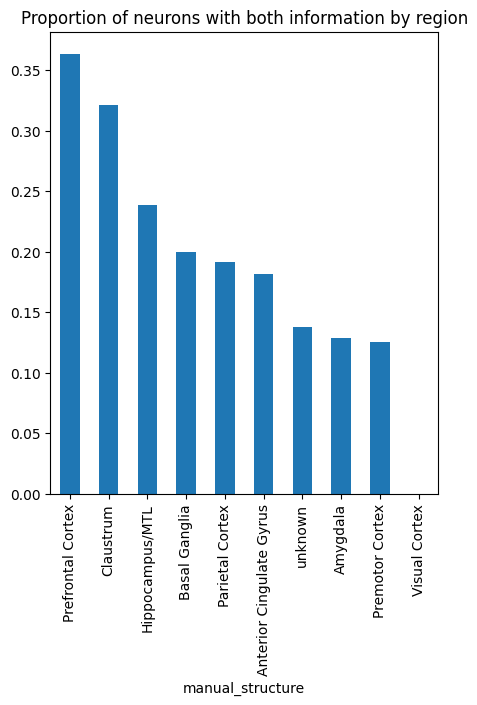

In [31]:
portions = filtered_pos.groupby("manual_structure").count()["UnitID"] / all_pos.groupby("manual_structure").count()["UnitID"]
portions = portions.sort_values(ascending=False)
ax = portions.plot.bar(figsize=(5, 6))
ax.set_title("Proportion of neurons with both information by region")

Text(0.5, 1.0, 'Proportion of neurons with RPE group information by region')

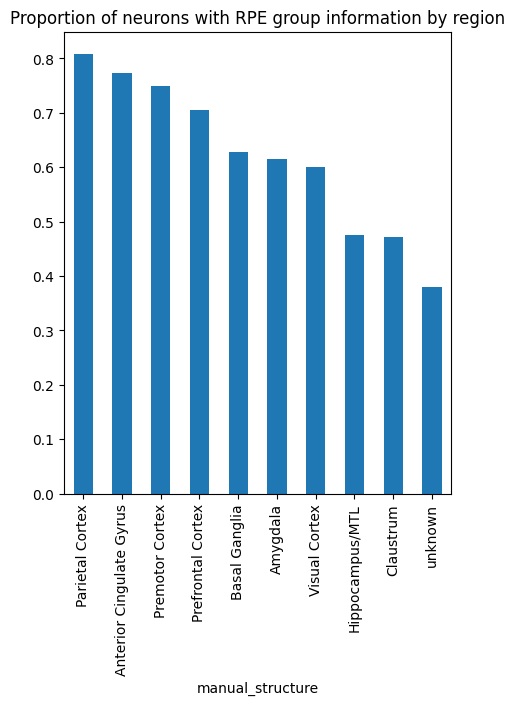

In [32]:
portions = just_rpe_pos.groupby("manual_structure").count()["UnitID"] / all_pos.groupby("manual_structure").count()["UnitID"]
portions = portions.sort_values(ascending=False)
ax = portions.plot.bar(figsize=(5, 6))
ax.set_title("Proportion of neurons with RPE group information by region")

Text(0.5, 1.0, 'Proportion of neurons with feature information by region')

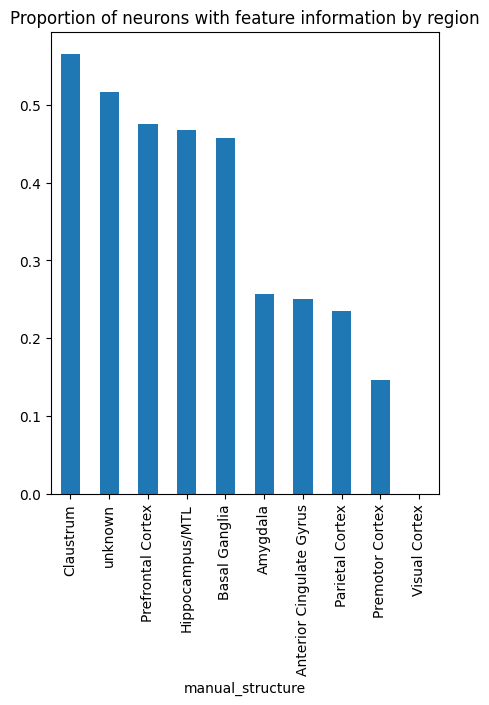

In [33]:
portions = just_feature_pos.groupby("manual_structure").count()["UnitID"] / all_pos.groupby("manual_structure").count()["UnitID"]
portions = portions.sort_values(ascending=False)
ax = portions.plot.bar(figsize=(5, 6))
ax.set_title("Proportion of neurons with feature information by region")

In [34]:
filtered_pos.session.unique()

array(['20180709', '20180918', '20180912', '20181008', '20181002',
       '20180806', '20180801', '201807250001', '20181001', '20180802',
       '20180808', '20180924', '20180705', '20180926', '20180921',
       '20180925', '20180803', '20180712', '20180928', '20180910'],
      dtype=object)